In [1]:
%load_ext autoreload
%autoreload 2

In [80]:
should_skip = False

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq accelerate transformers ftfy
  !pip install -q gpustat gdown
  !pip install -q pytorch_lightning

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [82]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
To: /content/my_concept_gt.zip
100% 14.7k/14.7k [00:00<00:00, 39.2MB/s]
mkdir: cannot create directory ‘./my_concept_gt/’: File exists
Archive:  my_concept_gt.zip
  inflating: my_concept_gt/1.png     
  inflating: my_concept_gt/0.png     


In [6]:
%cd /content/
sys.path.append("/content/slime-experiments/")

/content


In [7]:
!rm -rf slime-experiments/
!git clone https://github.com/andrew-healey/slime-experiments
!cd slime-experiments && git rev-parse --short HEAD

Cloning into 'slime-experiments'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 109 (delta 64), reused 80 (delta 35), pack-reused 0
Receiving objects: 100% (109/109), 1.29 MiB | 8.21 MiB/s, done.
Resolving deltas: 100% (64/64), done.
7c743a9


In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule

In [88]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=50
)

In [10]:
loader = data_module.train_dataloader()
l=0
for i in loader: l+=1
l

50

In [11]:
slime = SLiME(
    use_self_attn=False,
).cuda()

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir run

In [35]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=50,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_multiplier    | Multiplier      | 4     
  | other params    

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


In [ ]:
slime.cuda()

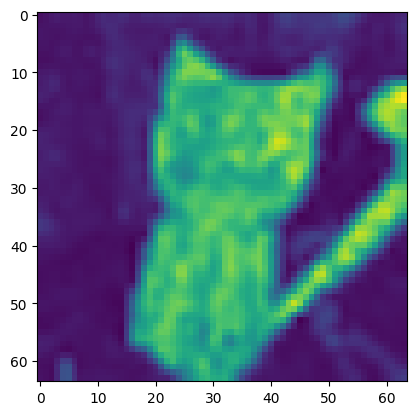

In [47]:
import matplotlib.pyplot as plt
plt.imshow(slime.latest_preds[-1].swapaxes(1,2).reshape((2,2,64,64))[0,1])

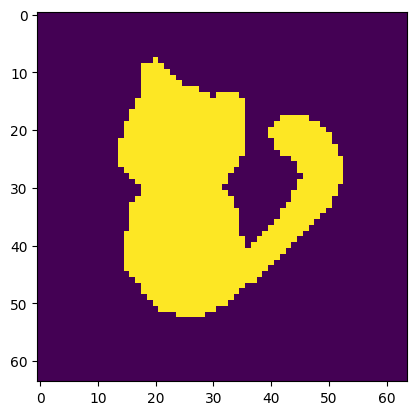

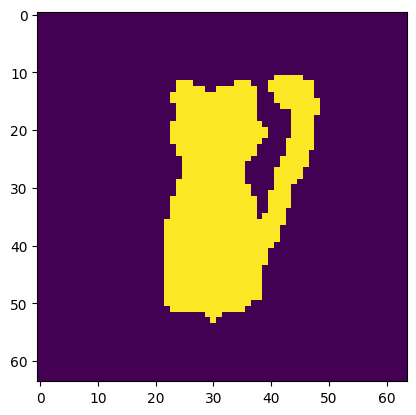

In [90]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  break

import matplotlib.pyplot as plt
for i in range(len(out_mask)):
  plt.imshow(out_mask[i].reshape((64,64)))
  plt.show()

In [ ]:
!cd /content/slime-experiments/ && git diff